In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === Load datasets ===
labeled_df = pd.read_csv('labeled_thermal_features.csv')
unlabeled_df = pd.read_csv('thermal_frame_features.csv')

# === Select feature columns (exclude label + frame info) ===
feature_cols = [col for col in labeled_df.columns if col not in ['Frame', 'Porosity Label']]
X_labeled = labeled_df[feature_cols]
y_labeled = labeled_df['Porosity Label']
X_unlabeled = unlabeled_df[feature_cols]

# === Scale features ===
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# === Train Isolation Forest ===
# Set contamination to estimated anomaly ratio: 49 / 1400 ≈ 0.035
iso_forest = IsolationForest(n_estimators=100, contamination=0.045, random_state=42)
iso_forest.fit(X_labeled_scaled)

# === Predict anomalies ===
# Returns: 1 = normal, -1 = anomaly → we convert to 0 (normal), 1 (anomaly)
pred_labeled = iso_forest.predict(X_labeled_scaled)
pred_unlabeled = iso_forest.predict(X_unlabeled_scaled)

pred_labeled = np.where(pred_labeled == -1, 1, 0)
pred_unlabeled = np.where(pred_unlabeled == -1, 1, 0)

# === Evaluate on labeled dataset ===
print("Evaluation on labeled data:")
print(confusion_matrix(y_labeled, pred_labeled))
print(classification_report(y_labeled, pred_labeled))
print("Accuracy:", accuracy_score(y_labeled, pred_labeled))

# === Save predictions for unlabeled data ===
unlabeled_df['IF_Anomaly'] = pred_unlabeled
unlabeled_df.to_csv('isolation_forest_predictions.csv', index=False)
print("Isolation Forest predictions saved to isolation_forest_predictions.csv")


Evaluation on labeled data:
[[1473   20]
 [  20   51]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1493
           1       0.72      0.72      0.72        71

    accuracy                           0.97      1564
   macro avg       0.85      0.85      0.85      1564
weighted avg       0.97      0.97      0.97      1564

Accuracy: 0.9744245524296675
Isolation Forest predictions saved to isolation_forest_predictions.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load pseudo-labeled data (from Isolation Forest output)
pseudo_df = pd.read_csv('isolation_forest_predictions.csv')

# Load real labeled data
labeled_df = pd.read_csv('labeled_thermal_features.csv')

# Merge for consistent features
feature_cols = [col for col in pseudo_df.columns if col not in ['Frame', 'IF_Anomaly']]
X_pseudo = pseudo_df[feature_cols]
pseudo_labels = pseudo_df['IF_Anomaly']

# Optional: Normalize (use same scaler if you already have it)
scaler = StandardScaler()
X_pseudo_scaled = scaler.fit_transform(X_pseudo)

# --- Select most confident pseudo-labels (optional step) ---
# You can skip this if you trust all predictions, or do confidence filtering later
# For now, assume we're using all pseudo-labeled data

pseudo_labeled_df = pd.DataFrame(X_pseudo_scaled, columns=feature_cols)
pseudo_labeled_df['Label'] = pseudo_labels

# Prepare labeled data
X_real = labeled_df[feature_cols]
y_real = labeled_df['Porosity Label']
X_real_scaled = scaler.transform(X_real)

real_labeled_df = pd.DataFrame(X_real_scaled, columns=feature_cols)
real_labeled_df['Label'] = y_real

# Combine real and pseudo-labeled data
combined_df = pd.concat([real_labeled_df, pseudo_labeled_df], ignore_index=True)

# Prepare X, y for training
X_combined = combined_df[feature_cols].values
y_combined = combined_df['Label'].values

print("Pseudo-labeled + real labeled dataset shape:", X_combined.shape)
print("Class distribution:", np.bincount(y_combined.astype(int)))


Pseudo-labeled + real labeled dataset shape: (3128, 11)
Class distribution: [2986  142]


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Build the CNN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=32,
                    verbose=1)

# Evaluate
y_pred = model.predict(X_test).flatten()
y_pred_classes = (y_pred > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_classes)
cm = confusion_matrix(y_test, y_pred_classes)
report = classification_report(y_test, y_pred_classes)

print("\n✅ Test Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


Training shape: (2502, 11)
Test shape: (626, 11)
Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9306 - loss: 0.4318 - val_accuracy: 0.9661 - val_loss: 0.1166
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.9753 - loss: 0.1284 - val_accuracy: 0.9780 - val_loss: 0.0737
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.9794 - loss: 0.0834 - val_accuracy: 0.9820 - val_loss: 0.0600
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.9768 - loss: 0.0623 - val_accuracy: 0.9800 - val_loss: 0.0639
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.9782 - loss: 0.0762 - val_accuracy: 0.9800 - val_loss: 0.0588
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.9842 - loss: 0.0474 - val_accuracy: 0.9800 - val_loss: 0.0569
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.9800 - loss: 0.0608 - val_accuracy: 0.9840 - val_loss: 0.0520
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.9837 - loss: 0.0450 - val_accuracy: 0.9880 - val_lo

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
✅ Accuracy on Test Set: 0.9888

📊 Confusion Matrix:
 [[595   3]
 [  4  24]]

📋 Classification Report:
               precision    recall  f1-score   support

           0     0.9933    0.9950    0.9942       598
           1     0.8889    0.8571    0.8727        28

    accuracy                         0.9888       626
   macro avg     0.9411    0.9261    0.9334       626
weighted avg     0.9887    0.9888    0.9887       626



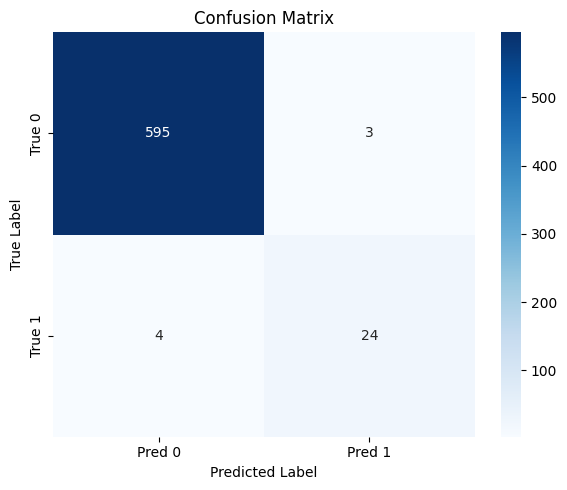

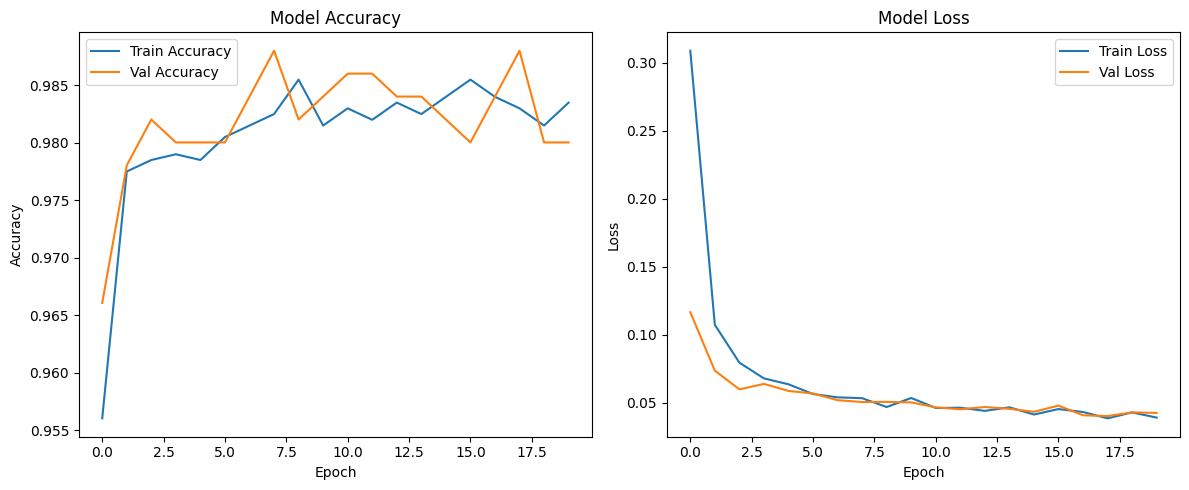

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test).flatten()
y_pred_classes = (y_pred > 0.5).astype(int)

# Accuracy & Report
acc = accuracy_score(y_test, y_pred_classes)
cm = confusion_matrix(y_test, y_pred_classes)
report = classification_report(y_test, y_pred_classes, digits=4)

print("✅ Accuracy on Test Set:", round(acc, 4))
print("\n📊 Confusion Matrix:\n", cm)
print("\n📋 Classification Report:\n", report)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()